In [30]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

In [4]:

def boa_to_df(boa):

    if len(boa['opponents_reps']) == 0:
        opponents = pd.DataFrame()
    else:
        opponents = pd.concat([
        pd.DataFrame({f"Opponent {i+1}":[v[0]], f"Representative {i+1}":[v[1]]}) for i,v in enumerate(boa['opponents_reps'])
        ], axis=1)
    
    return pd.concat([
    pd.DataFrame.from_dict({
        "Decision date" : [boa['date']],
        "Case number" : [boa['case_number']],
        "Application number" : [boa['application_number']],
        "Publication number" : [boa['publication_number']],
        "IPC pharma" : [boa['IPC pharma']],
        "IPC biosimilar" : [boa['IPC biosimilar']],
        "IPCs" : [", ".join(boa['IPC'])],
        "Language" : [boa['lang']],
        "Title of Invention" : [boa['title_of_invention']],
        "Patent Proprietor" : [boa['patent_proprietor']],
        "Headword" : [boa['headword']],
        "Provisions" : [", ".join(boa['provisions'])],
        "Keywords" : [', '.join(boa['keywords'])],
        "Decisions cited" : [', '.join(boa['decisions_cited'])],
        "Summary" : ['\n\n'.join(boa['summary'])],
        "Decision reasons" : ['\n\n'.join(boa['decision_reasons'])],
        "Order" : [', '.join(boa['order'])],
        "Order status" : [boa['Order_status']],
        "Order status web" : [boa['Order_status_web']],
        "Order status manual" : [boa['Order_status_manual']],
        "Opponents" : [', '.join(boa['opponents'])]  
    }),
    opponents
    ], axis=1)

def drop_duplicate_languages(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function returns unique cases without duplication across languages. Keeps only English if English + other lang is avbl, then keeps only german, and takes french for the rest.
    """
    en_cases = df[df['Language']=='EN']

    #Find the case numbers in df that are not in en_cases
    case_numbers = [x for x in df['Case number'].unique() if x not in en_cases['Case number'].unique()]

    # For the rest of the cases, keep the german versions only (in case they exist in both DE and FR)
    rest_de_df = df[(df['Case number'].isin(case_numbers)) & (df['Language'] == 'DE')]
    
    all_cases = pd.concat([en_cases, rest_de_df])

    # If there are any cases in french only, add them last.
    rest_fr_df = df[(~df['Case number'].isin(all_cases['Case number'])) & (df['Language'] == 'FR')]

    all_cases = pd.concat([all_cases, rest_fr_df])

    return all_cases

def load_data():
    with open('../data/raw/BOA_database_for_exercise_from_2020.json', 'r') as f:
        boa_pharma = json.load(f)
   
    boa_table = pd.concat([ boa_to_df(boa) for boa in boa_pharma], axis = 0)
    cases_df_dedup = drop_duplicate_languages(boa_table)

    return cases_df_dedup.reset_index(drop=True)

In [36]:
raw_data = load_data()
raw_data.columns

Index(['Decision date', 'Case number', 'Application number',
       'Publication number', 'IPC pharma', 'IPC biosimilar', 'IPCs',
       'Language', 'Title of Invention', 'Patent Proprietor', 'Headword',
       'Provisions', 'Keywords', 'Decisions cited', 'Summary',
       'Decision reasons', 'Order', 'Order status', 'Order status web',
       'Order status manual', 'Opponents', 'Opponent 1', 'Representative 1',
       'Opponent 2', 'Representative 2', 'Opponent 3', 'Representative 3',
       'Opponent 4', 'Representative 4', 'Opponent 5', 'Representative 5',
       'Opponent 6', 'Representative 6', 'Opponent 7', 'Representative 7',
       'Opponent 8', 'Representative 8', 'Opponent 9', 'Representative 9',
       'Opponent 10', 'Representative 10', 'Opponent 11', 'Representative 11',
       'Opponent 12', 'Representative 12', 'Opponent 13', 'Representative 13',
       'Opponent 14', 'Representative 14', 'Opponent 15', 'Representative 15',
       'Opponent 16', 'Representative 16', 'Opp

In [9]:
def preprocess_text(text_series):
    
    stop_words = set(stopwords.words('english'))
    stop_words.update('request')
    stop_words.update('claim')
    stop_words.update('composition')
    lemmatizer = WordNetLemmatizer()

    def clean(doc):
        tokens = word_tokenize(doc.lower())
        tokens = [t for t in tokens if t.isalpha()]
        tokens = [t for t in tokens if t not in stop_words]
        tokens = [lemmatizer.lemmatize(t, pos='n') for t in tokens]
        tokens = [lemmatizer.lemmatize(t, pos='v') for t in tokens]
        tokens = [lemmatizer.lemmatize(t, pos='a') for t in tokens]
        tokens = [lemmatizer.lemmatize(t, pos='r') for t in tokens]
        tokens = [lemmatizer.lemmatize(t, pos='s') for t in tokens]
        return tokens

    return text_series.dropna().apply(clean)

## What words are common in tht title?

- Popular words refer to chemistry (composition), processes, formulation,  treatments.
- There are domain specific keywords like 'composition'
- Note: Removing composition, method, etc. manually did not imporve topic modelling (these words were most common across all topics)

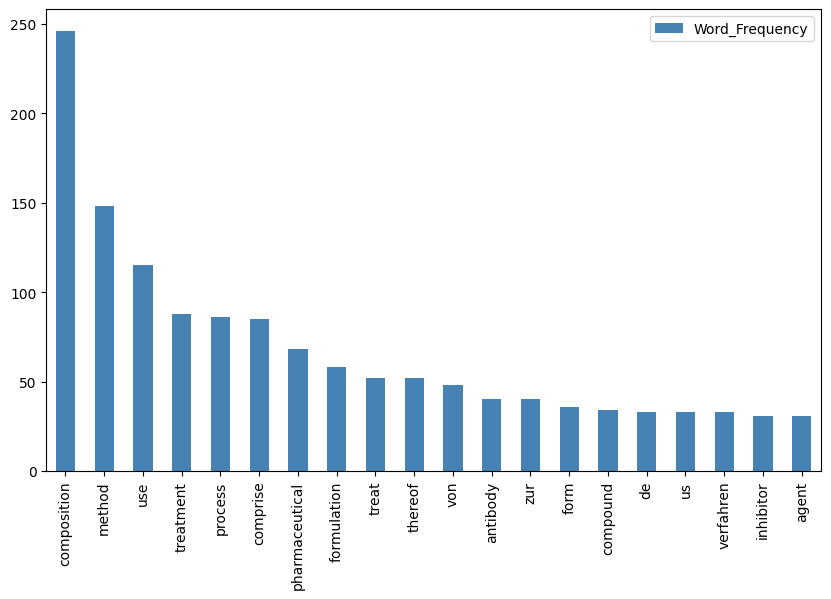

In [24]:
from collections import Counter
import itertools
texts = preprocess_text(raw_data['Title of Invention'])
all_words = list(itertools.chain.from_iterable(texts))
common_terms = Counter(all_words).most_common(100)
# common_terms
pd.DataFrame(Counter(all_words), index=['Word_Frequency']).T.sort_values('Word_Frequency', ascending=False).head(20).plot(kind='bar', figsize=(10, 6), color='steelblue');

# Which Opponents are common?

- 'Blank' opponent most common, falling sharply with Henkel as next, and many companies appearing 20-25 times
- 'Strawman' is interesting domain-specific detail - companies that sue anonymously?
- Numbers fall enough that you wouldnt split by target variable

<Axes: >

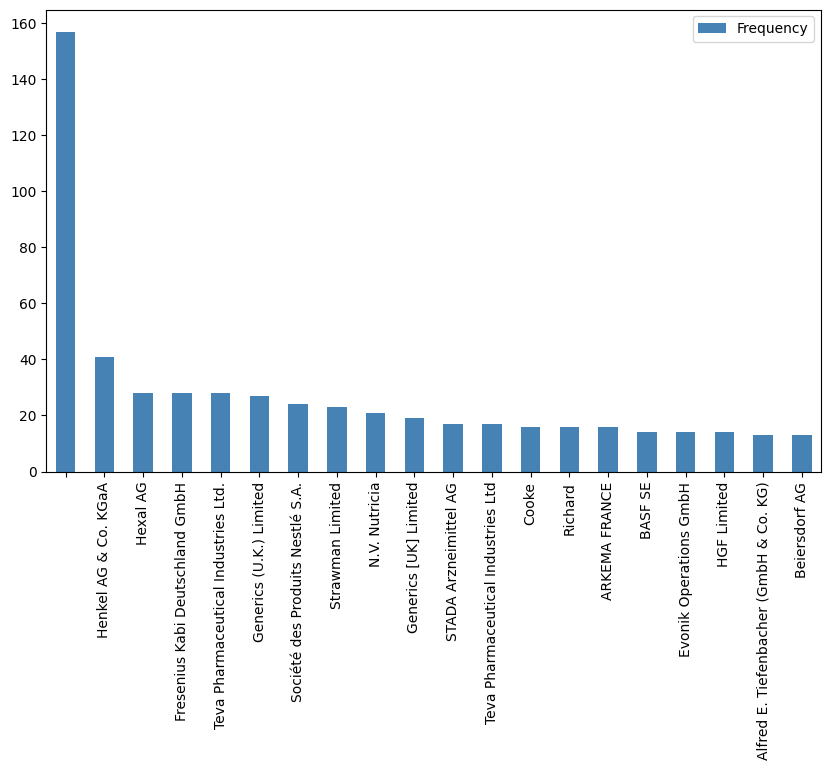

In [21]:
from collections import Counter
temp = Counter()
mySeries = raw_data['Opponents'].str.replace(', Inc.', ' Inc.').str.split(', ')
# mySeries = raw_data['Opponents'].str.split(', ')
for i in range(len(raw_data)):
    for j in mySeries.iloc[i]:
        temp[j] += 1


# temp.most_common(20)
pd.DataFrame(temp, index=['Frequency']).T.sort_values('Frequency', ascending=False).head(20).plot(kind='bar', figsize=(10, 6), color='steelblue')
        

Language
EN    826
DE     98
FR     25
Name: count, dtype: int64

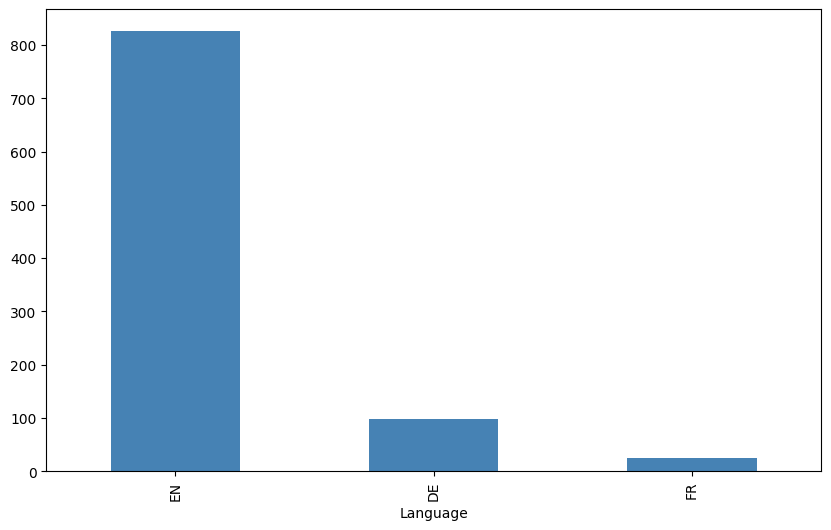

In [ ]:
raw_data['Language'].value_counts().plot(kind='bar', figsize=(10, 6), color='steelblue')
raw_data['Language'].value_counts()

# What IPCs are common in appeals data?

- Chemistry is 75% of the data, followed by operations, human necessities. Everything else is <10%

C (Chemistry, Metallurgy): 419 (74.29%)
A (Human Necessities): 50 (8.87%)
H (Electricity): 20 (3.55%)
B (Performing Operations, Transporting): 68 (12.06%)
G (Physics): 6 (1.06%)
F (Mechanical Engineering, Lighting, Heating, Weapons): 1 (0.18%)


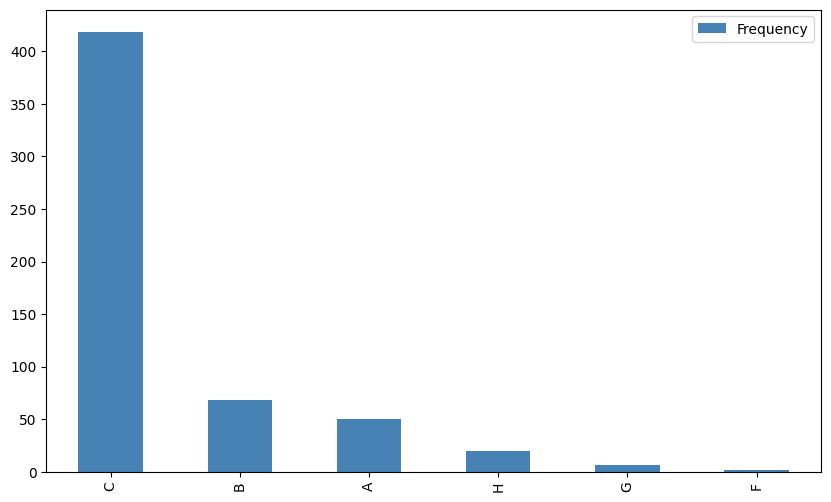

In [26]:
def get_IPC_classification(x):
    """
    This function returns the IPC classification of a case.
    """
    IPC_CLASSIFICATIONS = {'A': 'Human Necessities',
    'B': 'Performing Operations, Transporting',
    'C': 'Chemistry, Metallurgy',
    'D': 'Textiles, Paper',
    'E': 'Fixed Constructions',
    'F': 'Mechanical Engineering, Lighting, Heating, Weapons',
    'G': 'Physics',
    'H': 'Electricity'}

    return IPC_CLASSIFICATIONS[x]


# Learning: we have some non-pharma but they're not biosimilars.
from collections import Counter
my_counter = Counter()
raw_data[raw_data['IPC pharma'] == 0]['IPCs'].apply(lambda x: x.replace(' ','').split(',')).apply(lambda y: [x[0] for x in y]).apply(lambda x: my_counter.update(x));


# When we have non-pharma IPCs, the most common categories are 
for k in my_counter.keys():
    print(f"{k} ({get_IPC_classification(k)}): {my_counter[k]} ({100*my_counter[k]/np.sum([x for x in my_counter.values()]):.2f}%)")

# Learning: Chemistry is the most common category, and operations comes up much more commonly than for pharma (>12x)
pd.DataFrame(my_counter, index=['Frequency']).T.sort_values('Frequency', ascending=False).head(20).plot(kind='bar', figsize=(10, 6), color='steelblue');

# Which IPCs are common?

In [31]:
import nltk
from nltk import regexp_tokenize

def custom_tokenize(text: str):
    """
    Custom tokenizer that uses regex to split the text into tokens.
    Replaces all spaces with underscores before tokenization.
    """
    # Replace spaces with underscores
    text = text.replace(" ", "")
    
    # Define a regex pattern for tokenization
    pattern = r"\s|[\.,;']"
    tokens = regexp_tokenize(text, pattern, gaps=True)
    return tokens

def get_token_map(df, series_name: str):
    all_tokens = []
    for i in range(len(df)):
        tokens = custom_tokenize(df.iloc[i][series_name])
        all_tokens.extend([x for x in tokens if x not in all_tokens])

    tokens_mapper = {all_tokens[i]: i for i in range(len(all_tokens))}
    return tokens_mapper

def custom_one_hot_encoder(df, series_name: str, tokens_mapper: dict) -> pd.DataFrame:
    """
    Custom one-hot encoder that uses the provided tokens mapper to create a one-hot encoded DataFrame.
    """
    if tokens_mapper is None:
        tokens_mapper = get_token_map(df, series_name)
    
    # Initialize an empty DataFrame with the same index as df
    one_hot_df = pd.DataFrame(0, index=df.index, columns=tokens_mapper.keys())

    for i in range(len(df)):
        tokens = custom_tokenize(df.iloc[i][series_name])
        for token in tokens:
            one_hot_df.iloc[i][token] = 1

    return one_hot_df

def custom_ipc_one_hot_encoder(df, series_name: str, tokens_mapper: dict, keep_first_n_ipc_letters=6) -> pd.DataFrame:
    """
    Custom one-hot encoder that uses the provided tokens mapper to create a one-hot encoded DataFrame.
    """

    df[series_name] = df[series_name].apply(lambda x: ', '.join([x[:keep_first_n_ipc_letters]]))
    if tokens_mapper is None:
        tokens_mapper = get_token_map(df, series_name)
    
    # Initialize an empty DataFrame with the same index as df
    one_hot_df = pd.DataFrame(0, index=df.index, columns=tokens_mapper.keys())

    for i in range(len(df)):
        tokens = custom_tokenize(df.iloc[i][series_name])
        for token in tokens:
            one_hot_df.iloc[i][token] = 1

    return one_hot_df

one_hot_encoded_values = custom_one_hot_encoder(raw_data, 'Provisions', None)
one_hot_decision_cited = custom_one_hot_encoder(raw_data, 'Decisions cited', None)
one_hot_ipcs = custom_ipc_one_hot_encoder(raw_data, 'IPCs', None)
# Observation: Makes no sense to try and keep this as feature in the model, because (a) we want to predict without knowing the decision, and (b) very low number of citations per case.

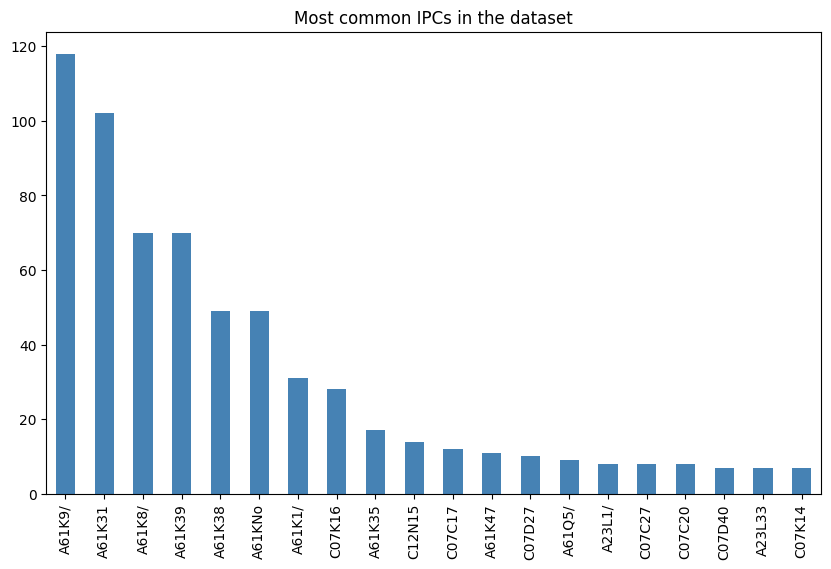

In [35]:
one_hot_ipcs.sum(axis=0).sort_values(ascending=False).head(20).plot(kind='bar', figsize=(10, 6), color='steelblue');
# set title to "Most common IPCs in the dataset"
plt.title("Most common IPCs in the dataset");

# Are the patterns to which provisions are cited?

### A spring layout shows the relative frequency of provisions cited together. The closer 2 provisions are, the more often they are cited together.

In [46]:
# Get a function that converts the provisions list in each row of the df and combines the information to create a network of which provisions are cited together. Return a networkx object

import networkx as nx

import matplotlib.pyplot as plt

def draw_spring(my_series, output_file=None, figsize=(15, 15)):
    provisions_network = get_provisions_cooccurrence_network(my_series)
    plt.figure(figsize=figsize)
    nx.draw(provisions_network, with_labels=True, pos=nx.spring_layout(provisions_network), 
            node_size=700, node_color='lightblue', font_size=5, font_weight='bold', 
            edge_color='gray', width=0.5)
    if output_file:
        plt.savefig(output_file, format='png', dpi=300)
    plt.show()

def get_provisions_cooccurrence_network(provisions_series: pd.Series) -> nx.Graph:
    """
    This function takes a pandas Series containing provisions lists (comma-separated strings),
    and creates a co-occurrence network of provisions cited together.

    Args:
        provisions_series (pd.Series): A pandas Series where each entry is a string of provisions separated by commas.

    Returns:
        nx.Graph: A NetworkX graph object representing the co-occurrence network of provisions.
    """
    # Initialize an empty graph
    G = nx.Graph()

    for provisions in provisions_series:
        # Split the provisions string into a list and remove whitespace
        provisions_list = provisions.replace(" ", "").split(",")
        
        # Add edges between all pairs of provisions in the list
        for i in range(len(provisions_list)):
            for j in range(i + 1, len(provisions_list)):
                provision_a = provisions_list[i]
                provision_b = provisions_list[j]
                
                # If the edge already exists, increment its weight
                if G.has_edge(provision_a, provision_b):
                    G[provision_a][provision_b]['weight'] += 1
                else:
                    # Otherwise, add the edge with an initial weight of 1
                    G.add_edge(provision_a, provision_b, weight=1)

    return G

# Example usage:
provisions_network = get_provisions_cooccurrence_network(raw_data['Provisions'])
#nx.draw(provisions_network, with_labels=True, pos=nx.spring_layout(provisions_network), node_size=700, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray', width=0.5)

# Usage: 
# 1. create a graph of all provisions cited
# 2. Create graph of all provisions cited in patent revocations
# 3. Create graph of all provisions cited in patent retained



### All Provisions, without filtering for success/failure of appeal

- 2 weakly connected blobs of related provisions,
- 3 small connected components quite 'far away'

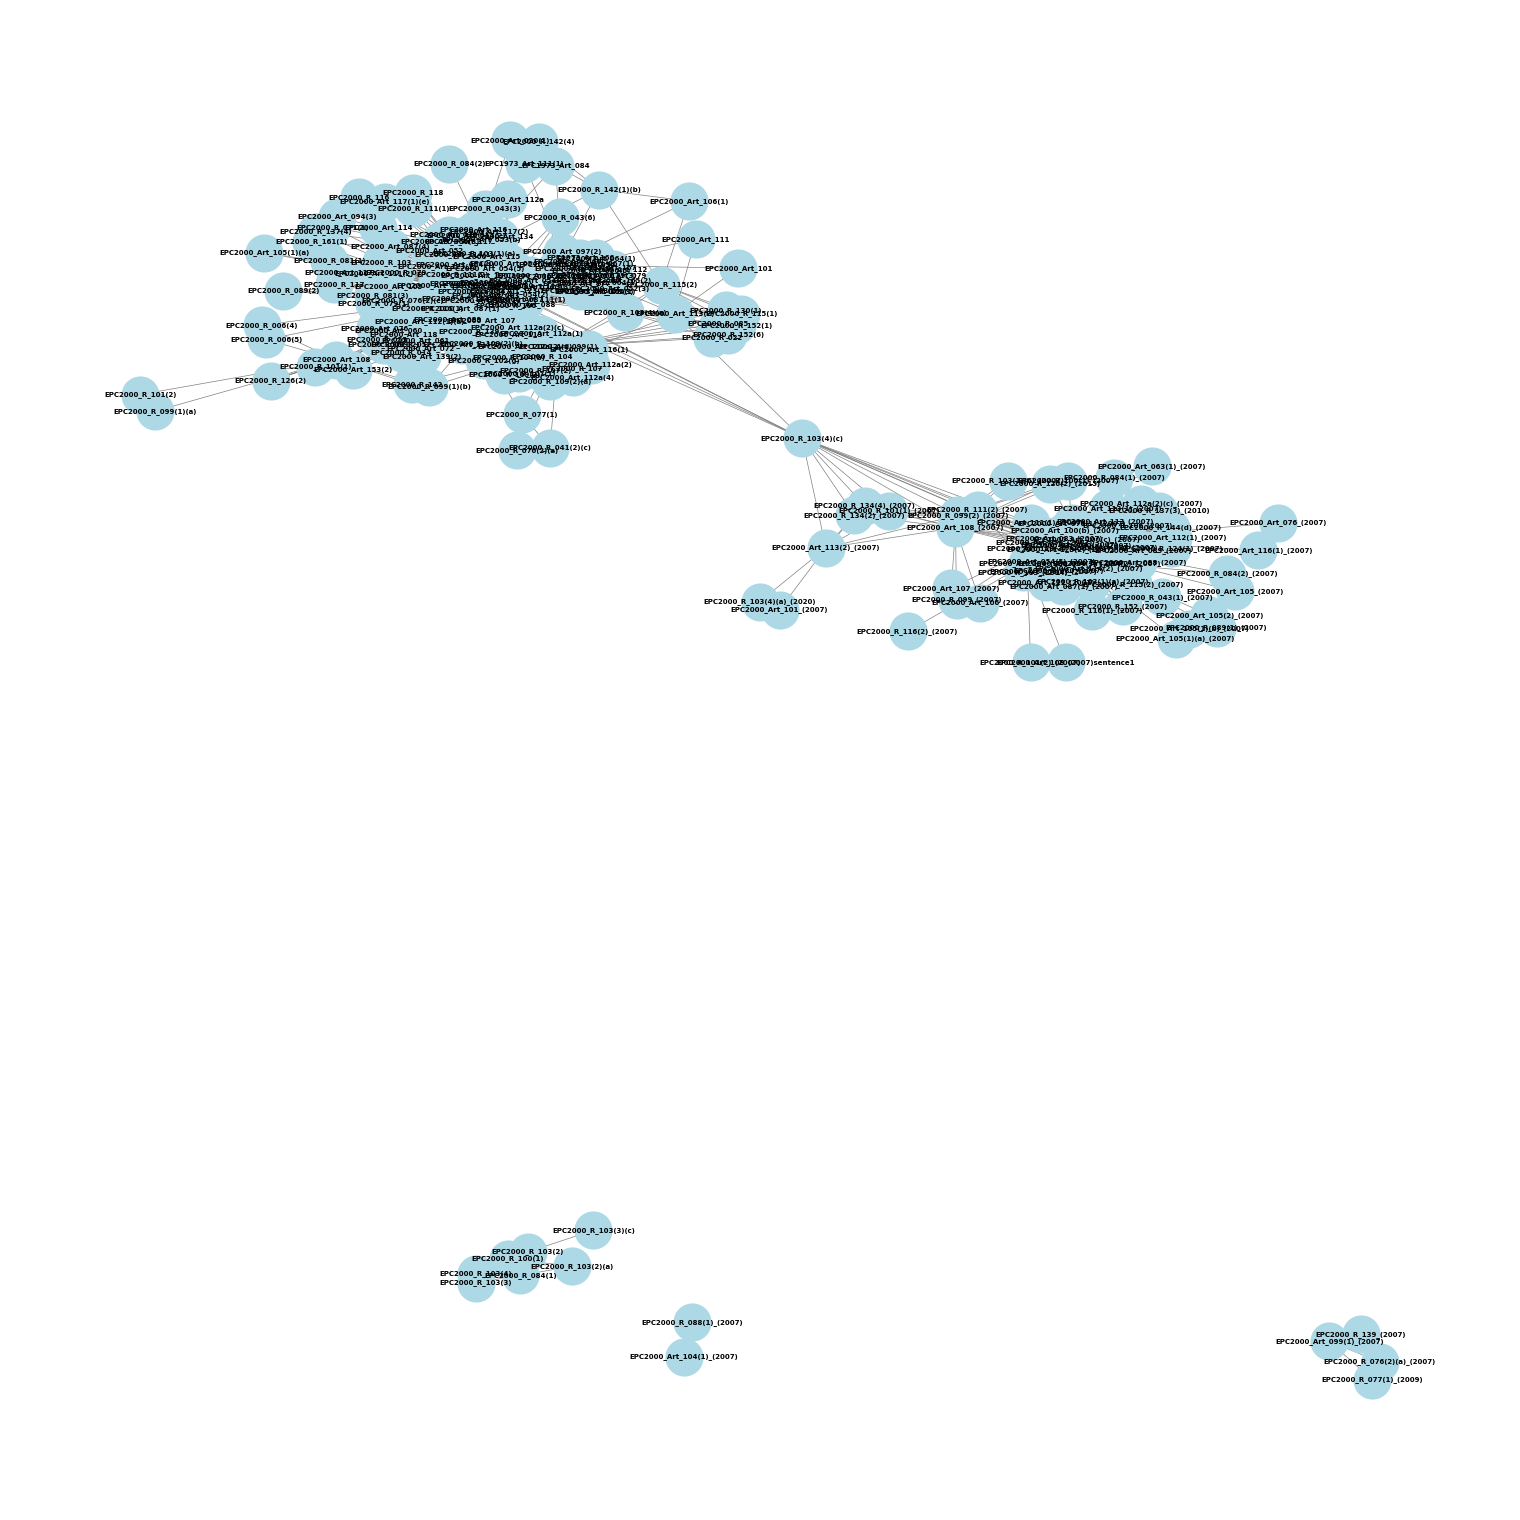

In [45]:
draw_spring(raw_data['Provisions'])

### Patent amended as maintained

Amended patents mostly refer to 2 sets of provisions

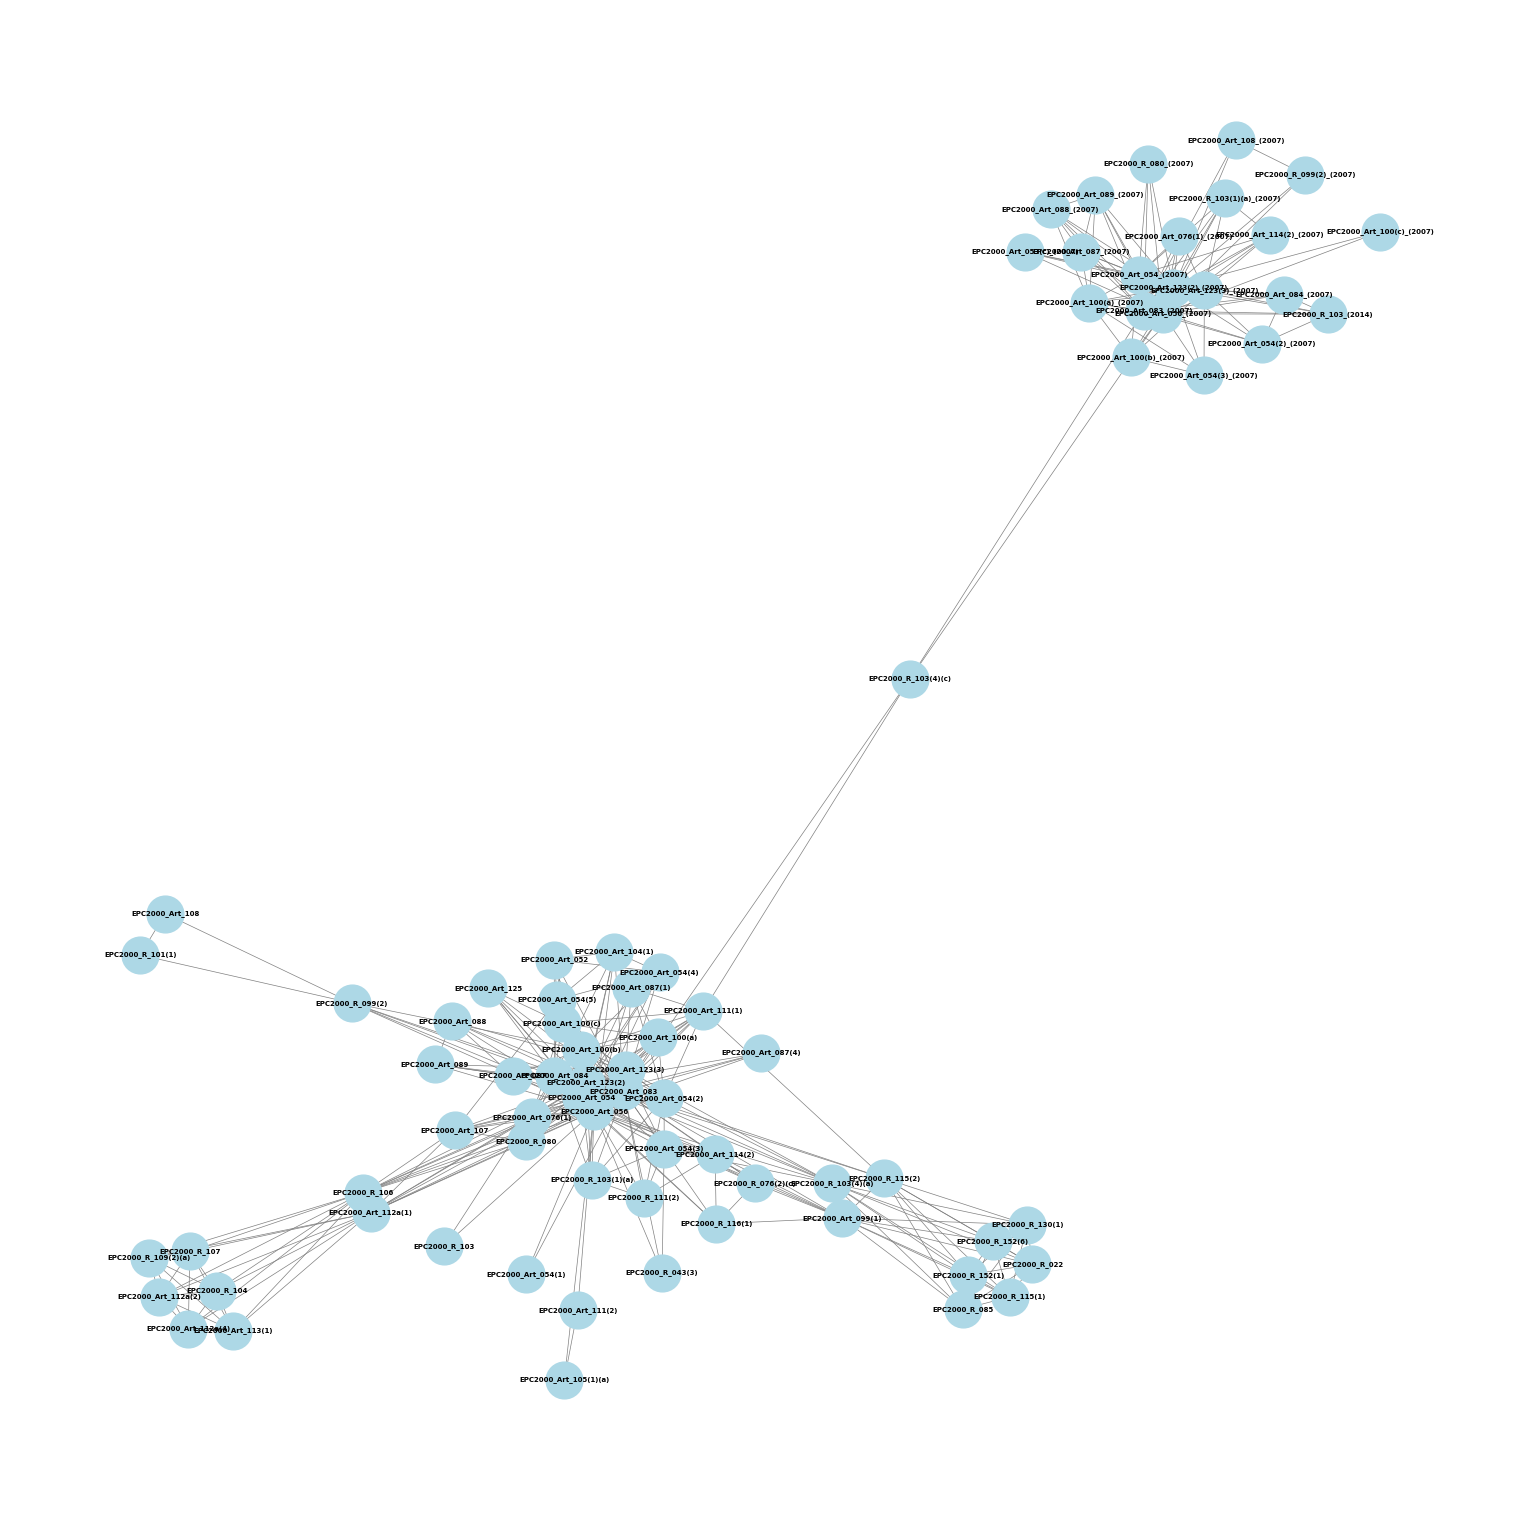

In [47]:
draw_spring(raw_data[raw_data['Order status']== 'patent maintained as amended']['Provisions'])

### Patent has been granted

- 4 groups of provisions seem common in patents that have been granted

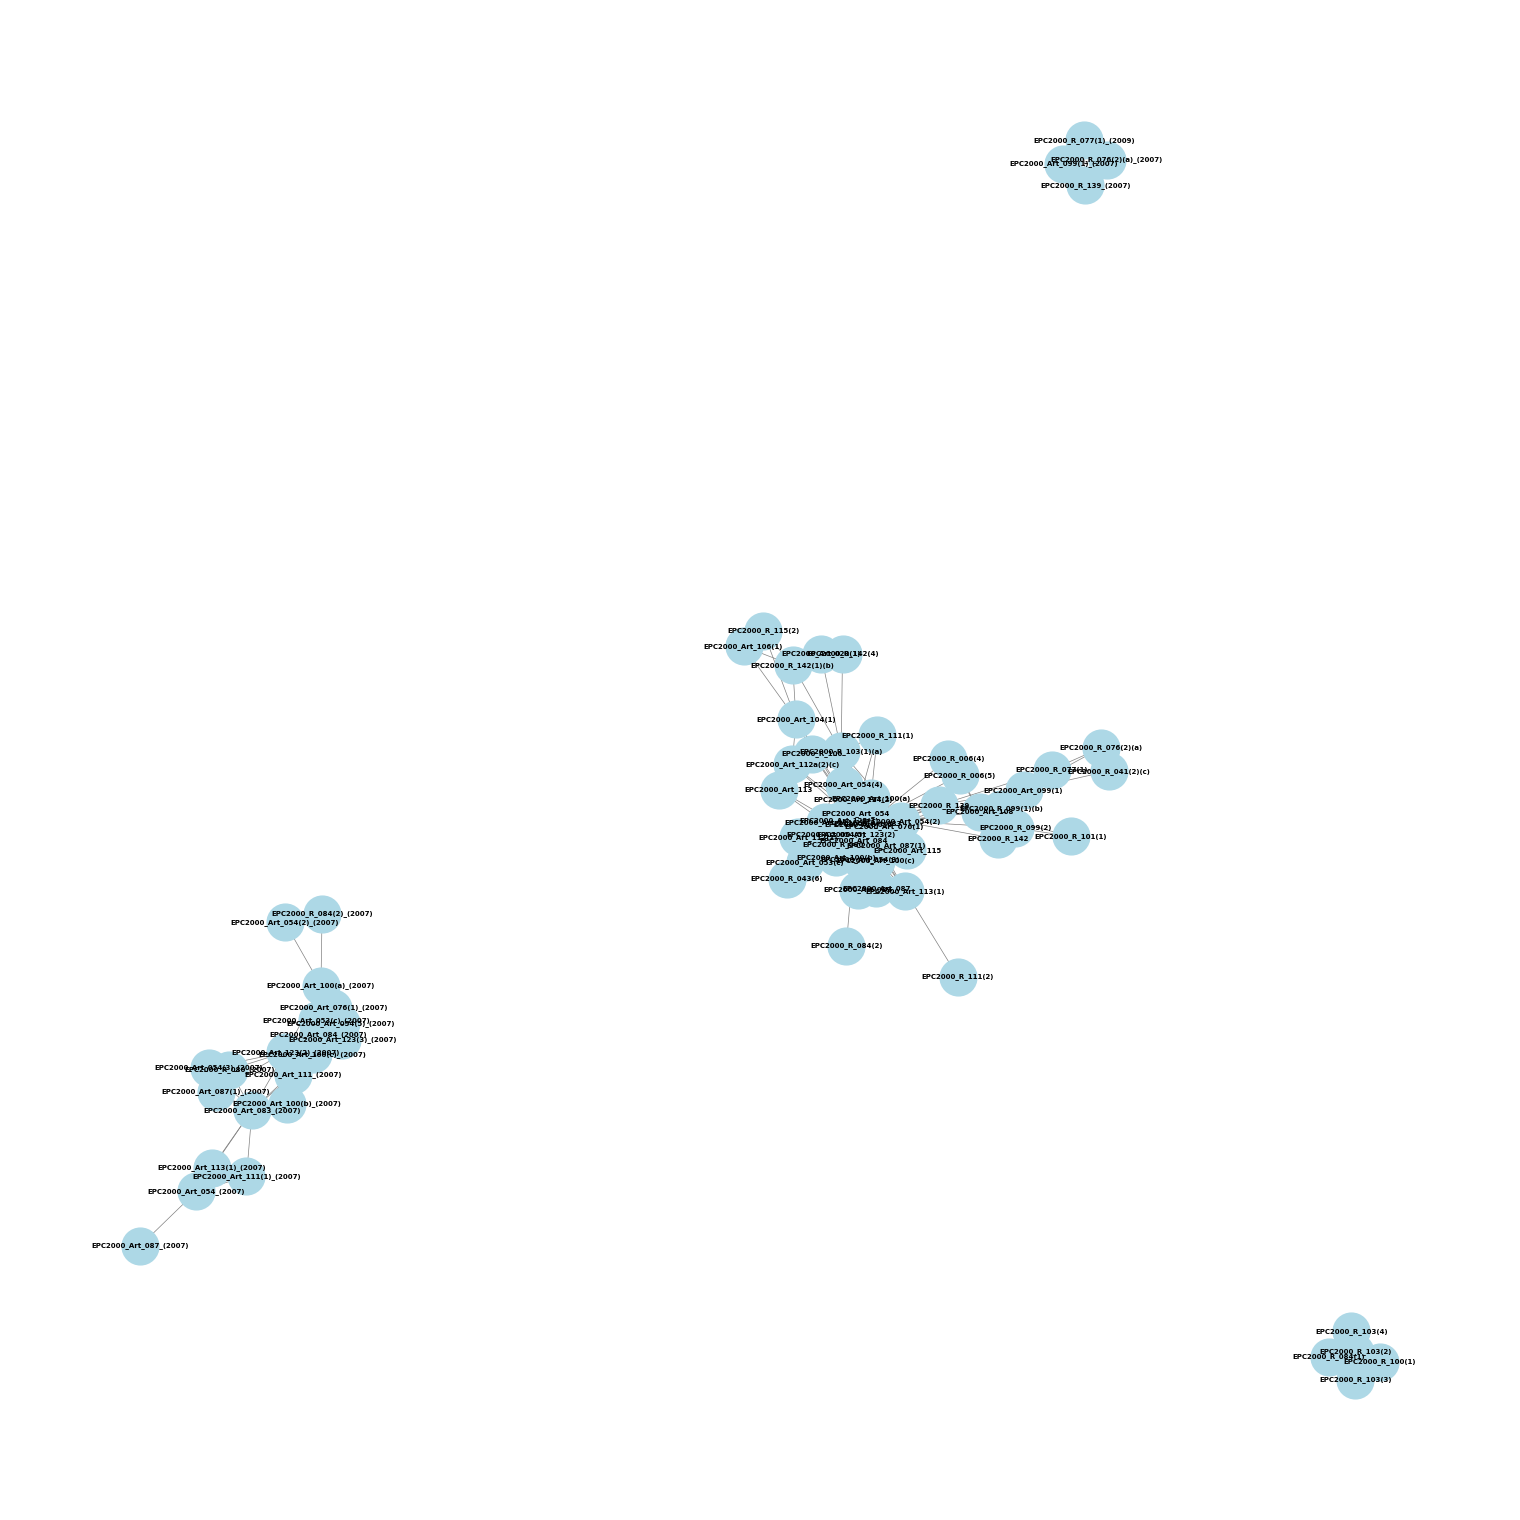

In [48]:
draw_spring(raw_data[raw_data['Order status']== 'the patent has been granted']['Provisions'])

# Opposition rejected
- Provisions mostly from 2 groups
- plus few isolated cases in the periphery

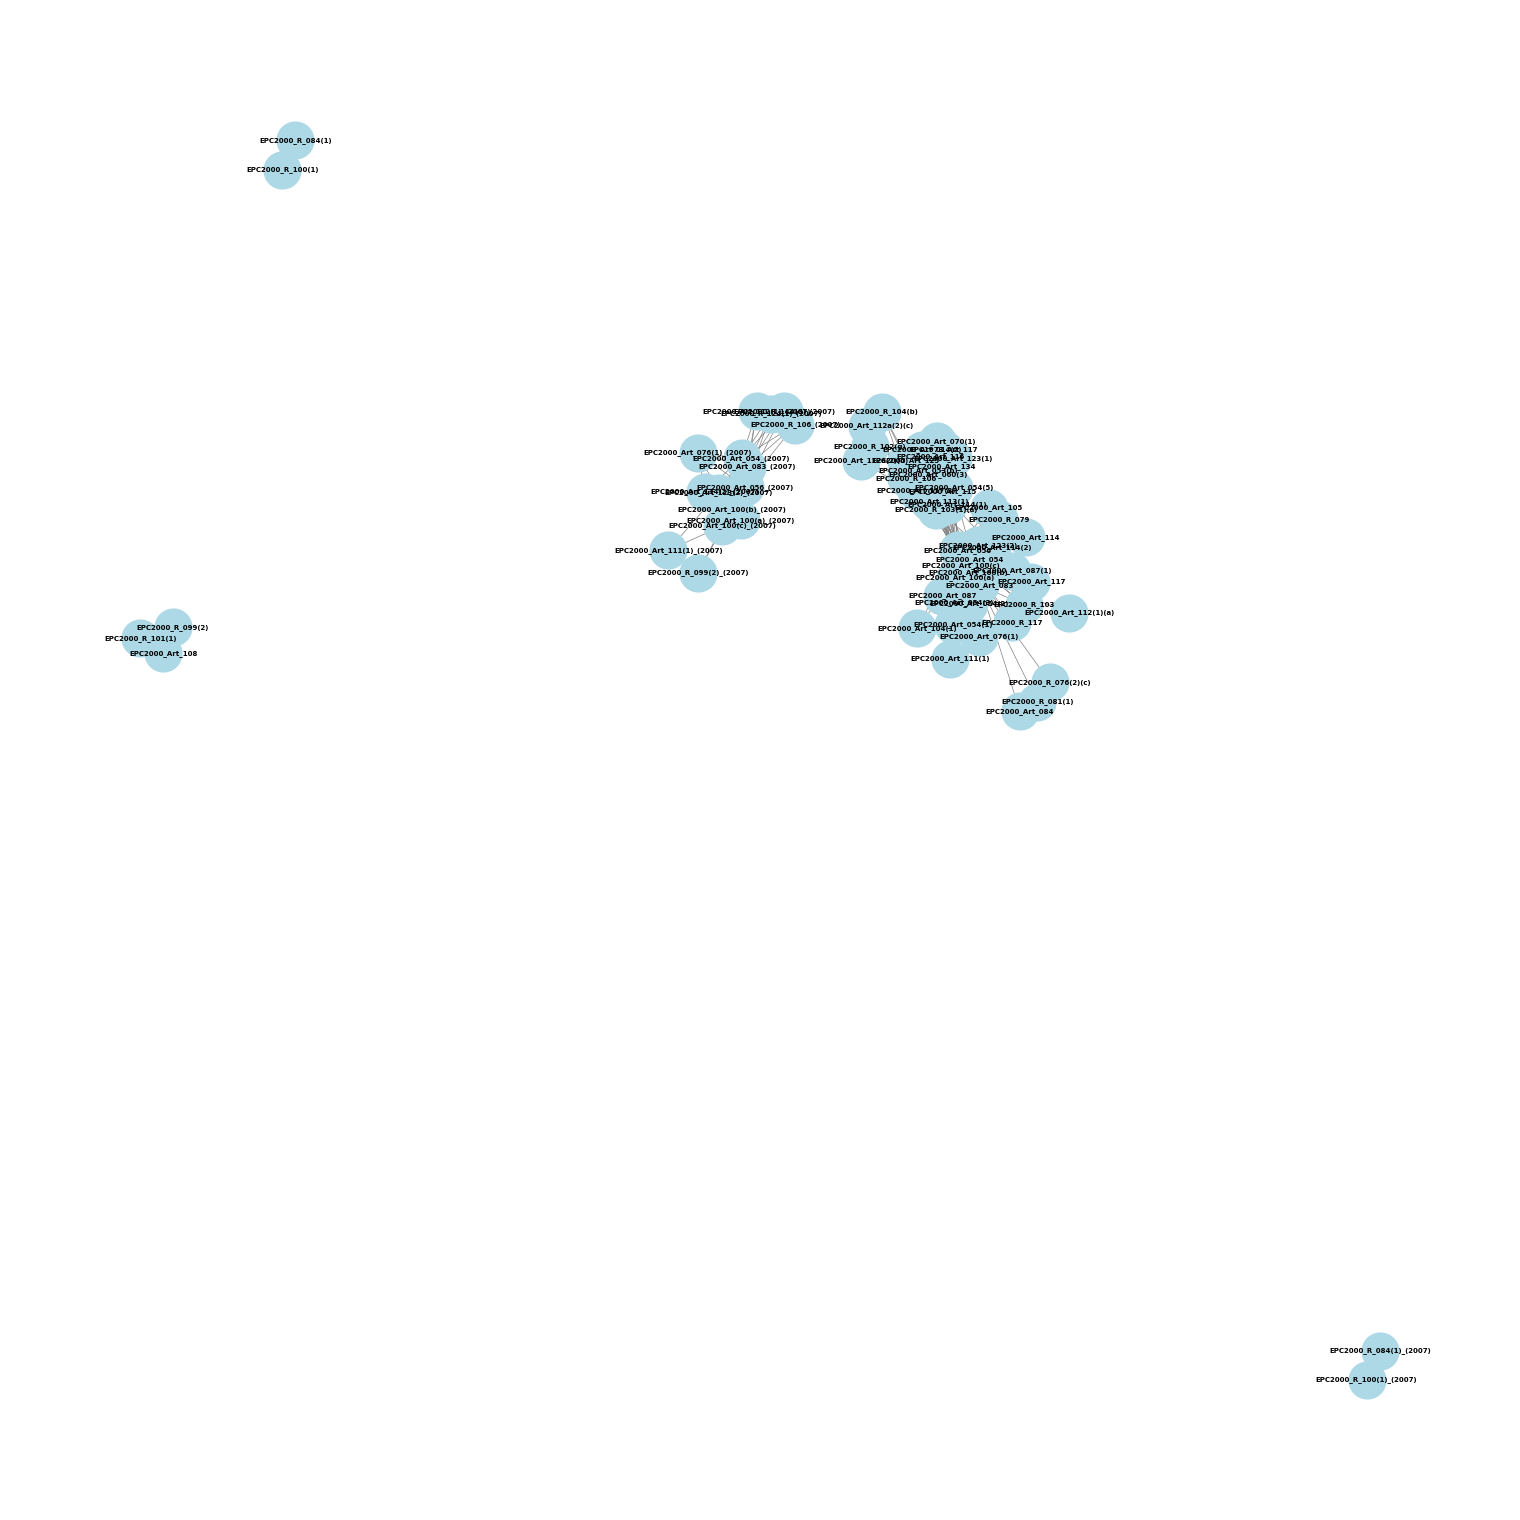

In [49]:
draw_spring(raw_data[raw_data['Order status']== 'opposition rejected']['Provisions'])